In [124]:
import ast
import wfdb
import numpy as np
import pandas as pd

import neurokit2 as nk
import warnings

from sklearn import metrics
from sklearn.preprocessing import normalize

import seaborn as sns; sns.set_theme()
from matplotlib import pyplot as plt
from ecg_features import get_ecg_features

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

Делим scp_codes на отдельные колонки. Проверяем сбалансированность классов.

In [63]:
SCP_LABELS = {
    'SR': 'sinus rhythm',
    'SARRH': 'sinus arrhythmia',
    'SBRAD': 'bradycardia',
    'STACH': 'sinus tachycardia',
    'AFIB': 'artrial fibrillation',
}
SCP_LABELS_ARR = ['SR', 'SARRH', 'SBRAD', 'STACH', 'AFIB']

DB_ROOT = 'data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'

Y = pd.read_csv(f'{DB_ROOT}/ptbxl_database.csv')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Split scp labels into separate columns
for scp_label in SCP_LABELS_ARR:
    Y[scp_label] = Y.scp_codes.apply(lambda x: int(scp_label in x))
    
Y['NORM'] = Y.scp_codes.apply(lambda x: int('NORM' in x))

# If one of the illnesses or normal
Y['labels_cnt'] = Y[SCP_LABELS_ARR].sum(axis=1)
Y['has_label'] = Y.labels_cnt > 0

Y.head(2)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,SR,SARRH,SBRAD,STACH,AFIB,NORM,labels_cnt,has_label
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0,1,1,True
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0,0,1,0,0,1,1,True


In [50]:
def count_nonzero(x):
    return np.sum(x > 0)

Y[['strat_fold', 'has_label', 'ecg_id'] + SCP_LABELS_ARR].groupby(['strat_fold', 'has_label']).agg(count_nonzero).reset_index()

,strat_fold,has_label,ecg_id,SR,SARRH,SBRAD,STACH,AFIB
0,1,False,126,0,0,0,0,0
1,1,True,2051,1678,77,63,82,151
2,2,False,131,0,0,0,0,0
3,2,True,2053,1678,77,64,83,151
4,3,False,144,0,0,0,0,0
5,3,True,2050,1678,77,63,82,151
6,4,False,121,0,0,0,0,0
7,4,True,2054,1679,77,64,83,151
8,5,False,121,0,0,0,0,0
9,5,True,2055,1679,78,64,83,152


Видим, что лейблов SR (синусовый ритм) слишком много. Оставим в каждом фолде по 100 псевдо-случайных ЭКГ со статусом SR.

In [51]:
def get_random_n(obj, n, replace=False, seed=123):
    np.random.seed(seed)
    return obj.loc[np.random.choice(obj.index, n, replace), :]
    
SR_ecgids = Y[Y.SR == 1].groupby('strat_fold', as_index=False).apply(lambda r: get_random_n(r, 100))['ecg_id'].values

Y = Y[(Y.SR == 0) | (Y.ecg_id.isin(SR_ecgids))]
Y[['strat_fold', 'has_label', 'ecg_id'] + SCP_LABELS_ARR].groupby(['strat_fold', 'has_label']).agg(count_nonzero).reset_index()

,strat_fold,has_label,ecg_id,SR,SARRH,SBRAD,STACH,AFIB
0,1,False,126,0,0,0,0,0
1,1,True,473,100,77,63,82,151
2,2,False,131,0,0,0,0,0
3,2,True,475,100,77,64,83,151
4,3,False,144,0,0,0,0,0
5,3,True,472,100,77,63,82,151
6,4,False,121,0,0,0,0,0
7,4,True,475,100,77,64,83,151
8,5,False,121,0,0,0,0,0
9,5,True,476,100,78,64,83,152


Cчитаем, как часто встречаются несколько labels для одной ЭКГ.<br>
P.S. Для данной задачи всего 3 случая.

In [52]:
print(f"ECG-examples with more than 1 label: {Y[Y.labels_cnt > 1].shape[0]}")
Y[Y.labels_cnt > 1][['report', 'scp_codes']]

ECG-examples with more than 1 label: 3


,report,scp_codes
283,"sinus bradycardia with sinus arrhythmia. the cause of the bradycardia is not evident. voltages are high in chest leads suggesting lvh. st segments are depressed in i, ii, avl, v4,5,6. this may be ...","{'LVH': 100.0, 'ISC_': 100.0, 'DIG': 100.0, 'VCLVH': 0.0, 'STD_': 0.0, 'SBRAD': 0.0, 'SARRH': 0.0}"
10362,"sinus bradycardia with sinus arrhythmia. the bradycardia may be physiological. st segments are elevated in i, ii, avf, v2-6, this is probably a normal variant. high v lead voltages are probably...","{'NORM': 100.0, 'SBRAD': 0.0, 'SARRH': 0.0}"
12282,sinus bradycardia with sinus arrhythmia. otherwise normal ecg. the cause of the bradycardia is not evident.,"{'NORM': 80.0, 'SBRAD': 0.0, 'SARRH': 0.0}"


Загрузим ЭКГ-сигналы и сделаем сглаживание.

In [18]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f"{path}/{f}") for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f"{path}/{f}") for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

X = load_raw_data(Y, 100, DB_ROOT)

Пример сглаживания

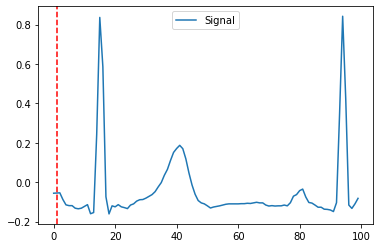

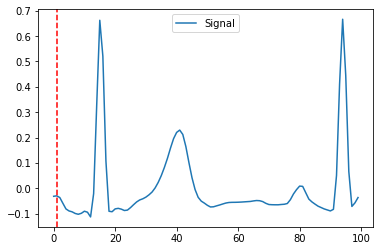

In [61]:
sample_len = 100
ecg_orig = X[np.where((Y.strat_fold == 10) & (Y.NORM == 1))][123][:, 0]
ecg_cleaned = nk.ecg_clean(ecg_orig, sampling_rate=100)
plot = nk.events_plot([1], ecg_orig[:sample_len])
plot = nk.events_plot([1], ecg_cleaned[:sample_len])

In [62]:
X = np.apply_along_axis(nk.ecg_clean, 1, X, 100)

Теперь смотрим на характерные признаки заболеваний.<br>

Отберем по 50 ЭКГ, где выставлен только 1 SCP-лейбл.<br>
Посмотрим на heatmap фичей по разным каналам

In [127]:
samples_v = []
for label in SCP_LABELS_ARR:
    samples_v.append(X[np.where((Y[label] == 1) & (Y.labels_cnt == 1))][:50])
    
samples_v.append(X[np.where((Y.NORM == 1) & (Y.labels_cnt == 0))][:50])

In [128]:
%%capture --no-stdout

n = 49
channel2features = {}
for channel_i in range(0, 12):
    print(f'Process channel {channel_i}')
    features_v = []
    for label_i, label in enumerate(SCP_LABELS_ARR + ['NORM']):
        curr_samples = samples_v[label_i][:, :, channel_i]
        features = np.zeros(n)
        for i in range(curr_samples.shape[0]):
            features += get_ecg_features(curr_samples[i, :])
        features = features / n
        features_v.append(features)
    channel2features[channel_i] = features_v

Process channel 0
Process channel 1
Process channel 2
Process channel 3
Process channel 4
Process channel 5
Process channel 6
Process channel 7
Process channel 8
Process channel 9
Process channel 10
Process channel 11


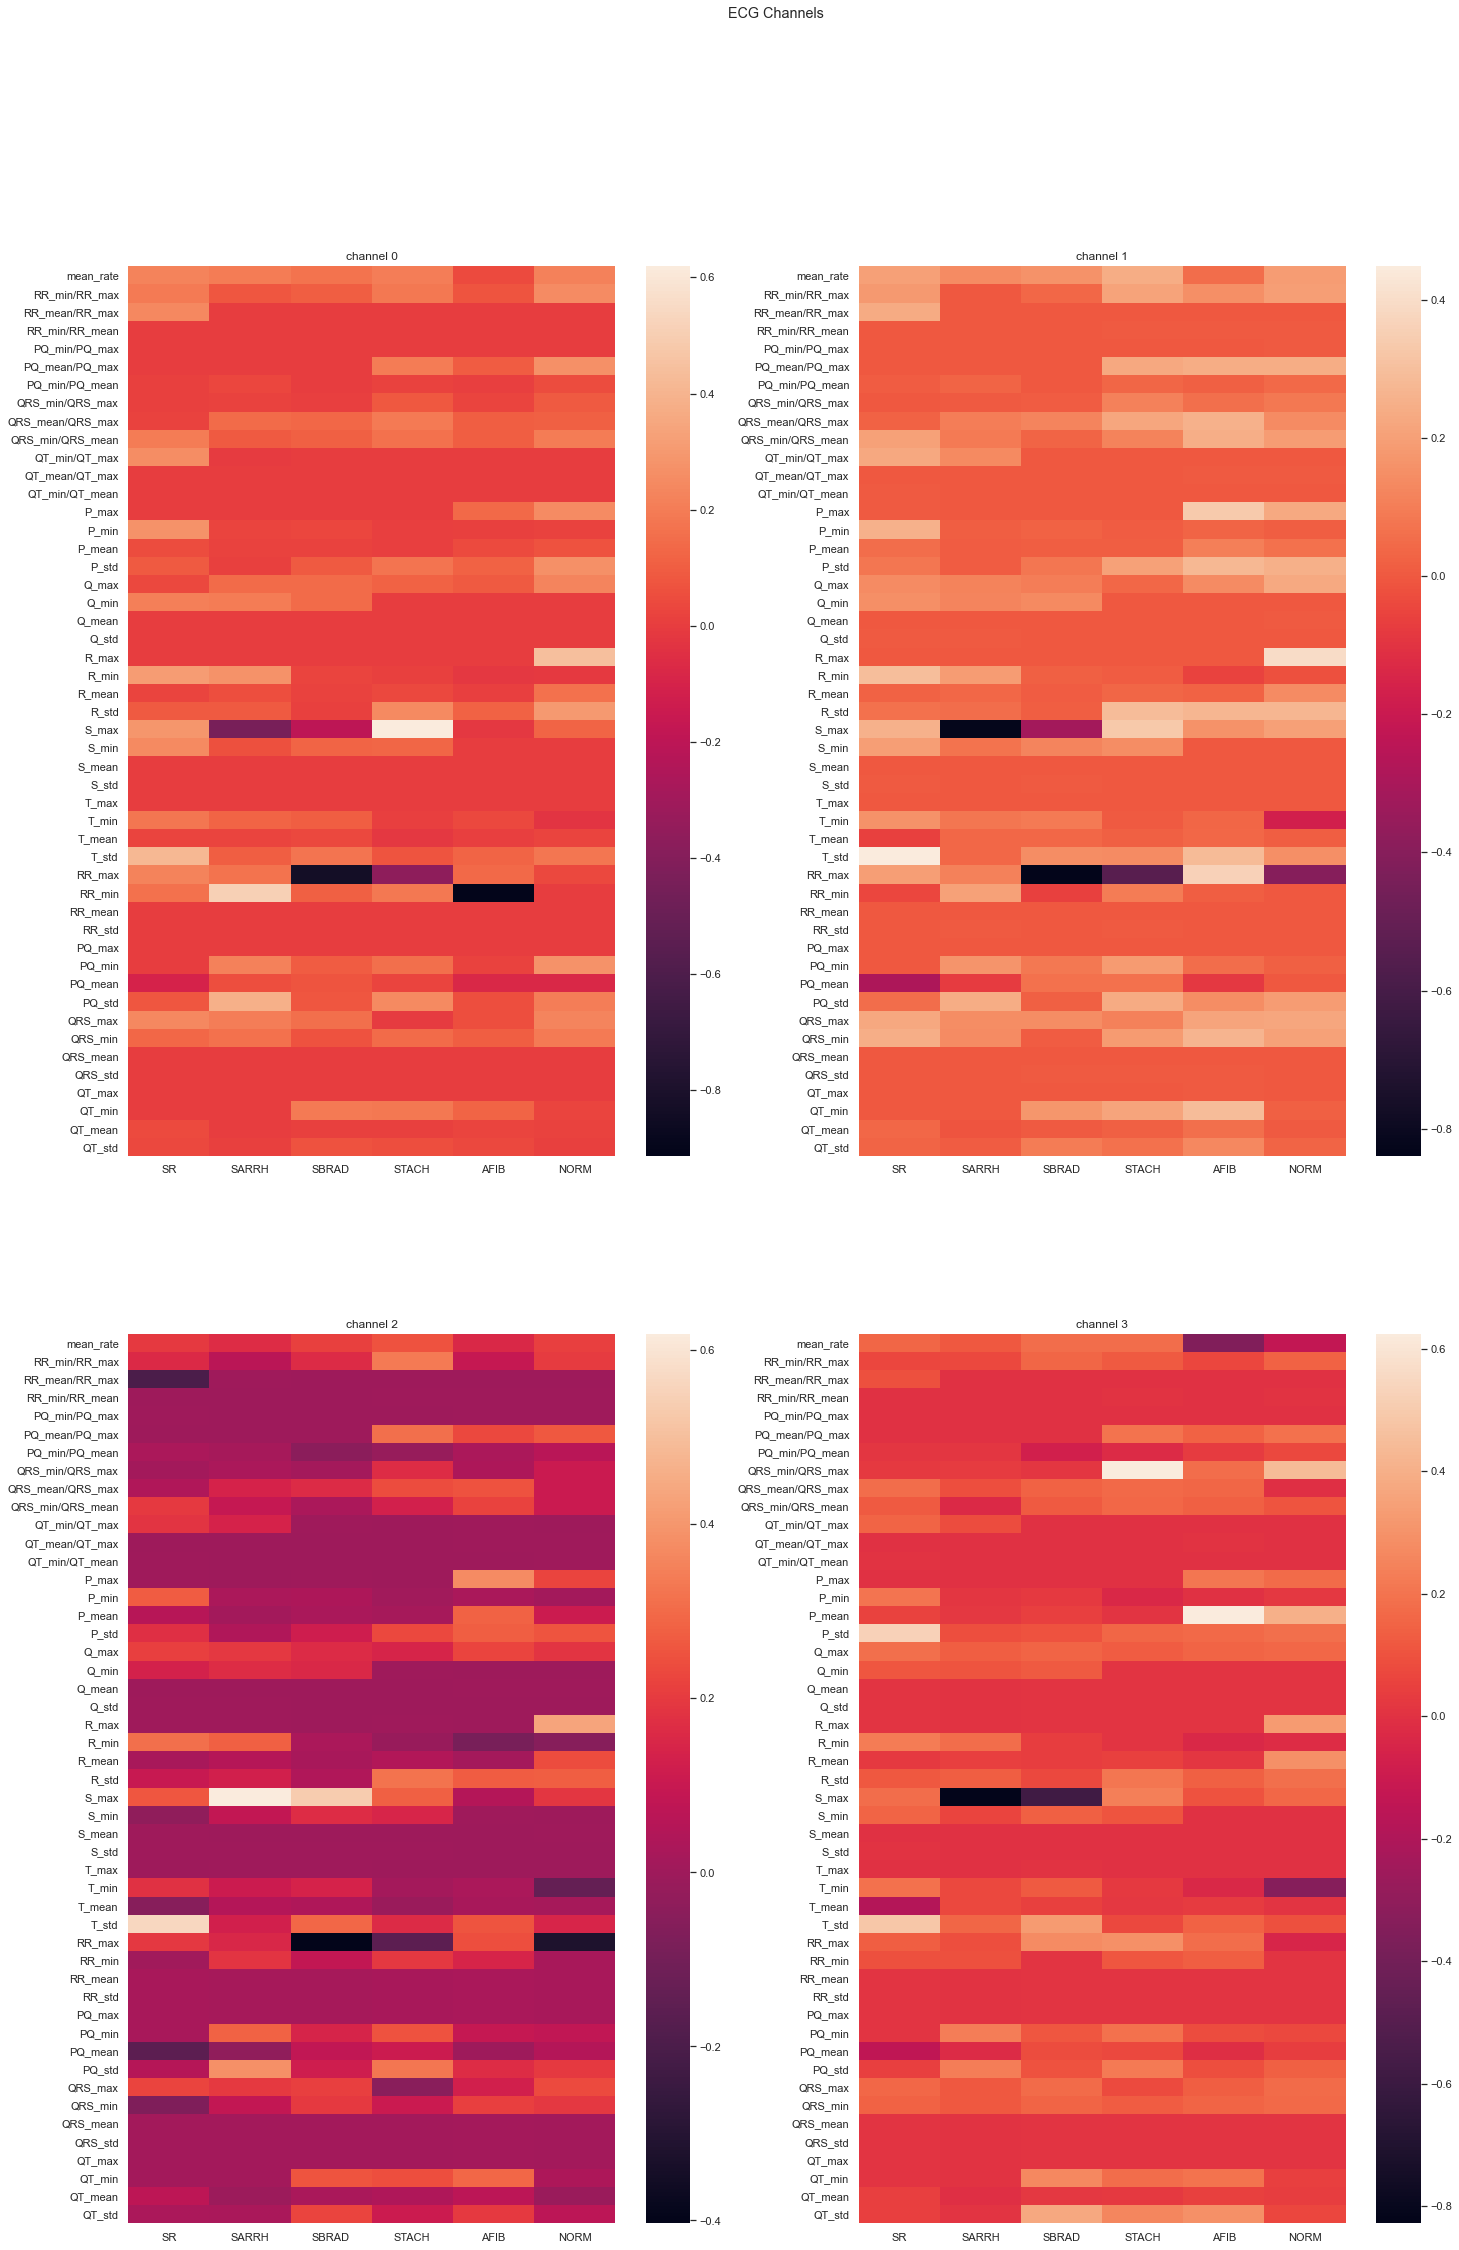

In [196]:
x_axis_labels = SCP_LABELS_ARR + ['NORM']
y_axis_labels = [
    "mean_rate",
    "RR_min/RR_max",
    "RR_mean/RR_max",
    "RR_min/RR_mean",
    "PQ_min/PQ_max",
    "PQ_mean/PQ_max",
    "PQ_min/PQ_mean",
    "QRS_min/QRS_max",
    "QRS_mean/QRS_max",
    "QRS_min/QRS_mean",
    "QT_min/QT_max",
    "QT_mean/QT_max",
    "QT_min/QT_mean",
    "P_max", "P_min", "P_mean", "P_std",
    "Q_max", "Q_min", "Q_mean", "Q_std",
    "R_max", "R_min", "R_mean", "R_std",
    "S_max", "S_min", "S_mean", "S_std",
    "T_max", "T_min", "T_mean", "T_std",
    "RR_max", "RR_min", "RR_mean", "RR_std",
    "PQ_max", "PQ_min", "PQ_mean", "PQ_std",
    "QRS_max", "QRS_min", "QRS_mean", "QRS_std",
    "QT_max", "QT_min", "QT_mean", "QT_std"
]

fig, axes = plt.subplots(2, 2, figsize=(24, 36))
fig.suptitle('ECG Channels')

for channel_i in range(0, 4):
    features_v = channel2features[channel_i]
    features_reshaped = np.concatenate(features_v).reshape(n, -1)
    i = int(channel_i/2)
    j = channel_i % 2
    sns.heatmap(normalize(features_reshaped, axis=0), ax=axes[i, j],
                xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    axes[i, j].set_title(f'channel {channel_i}')
    

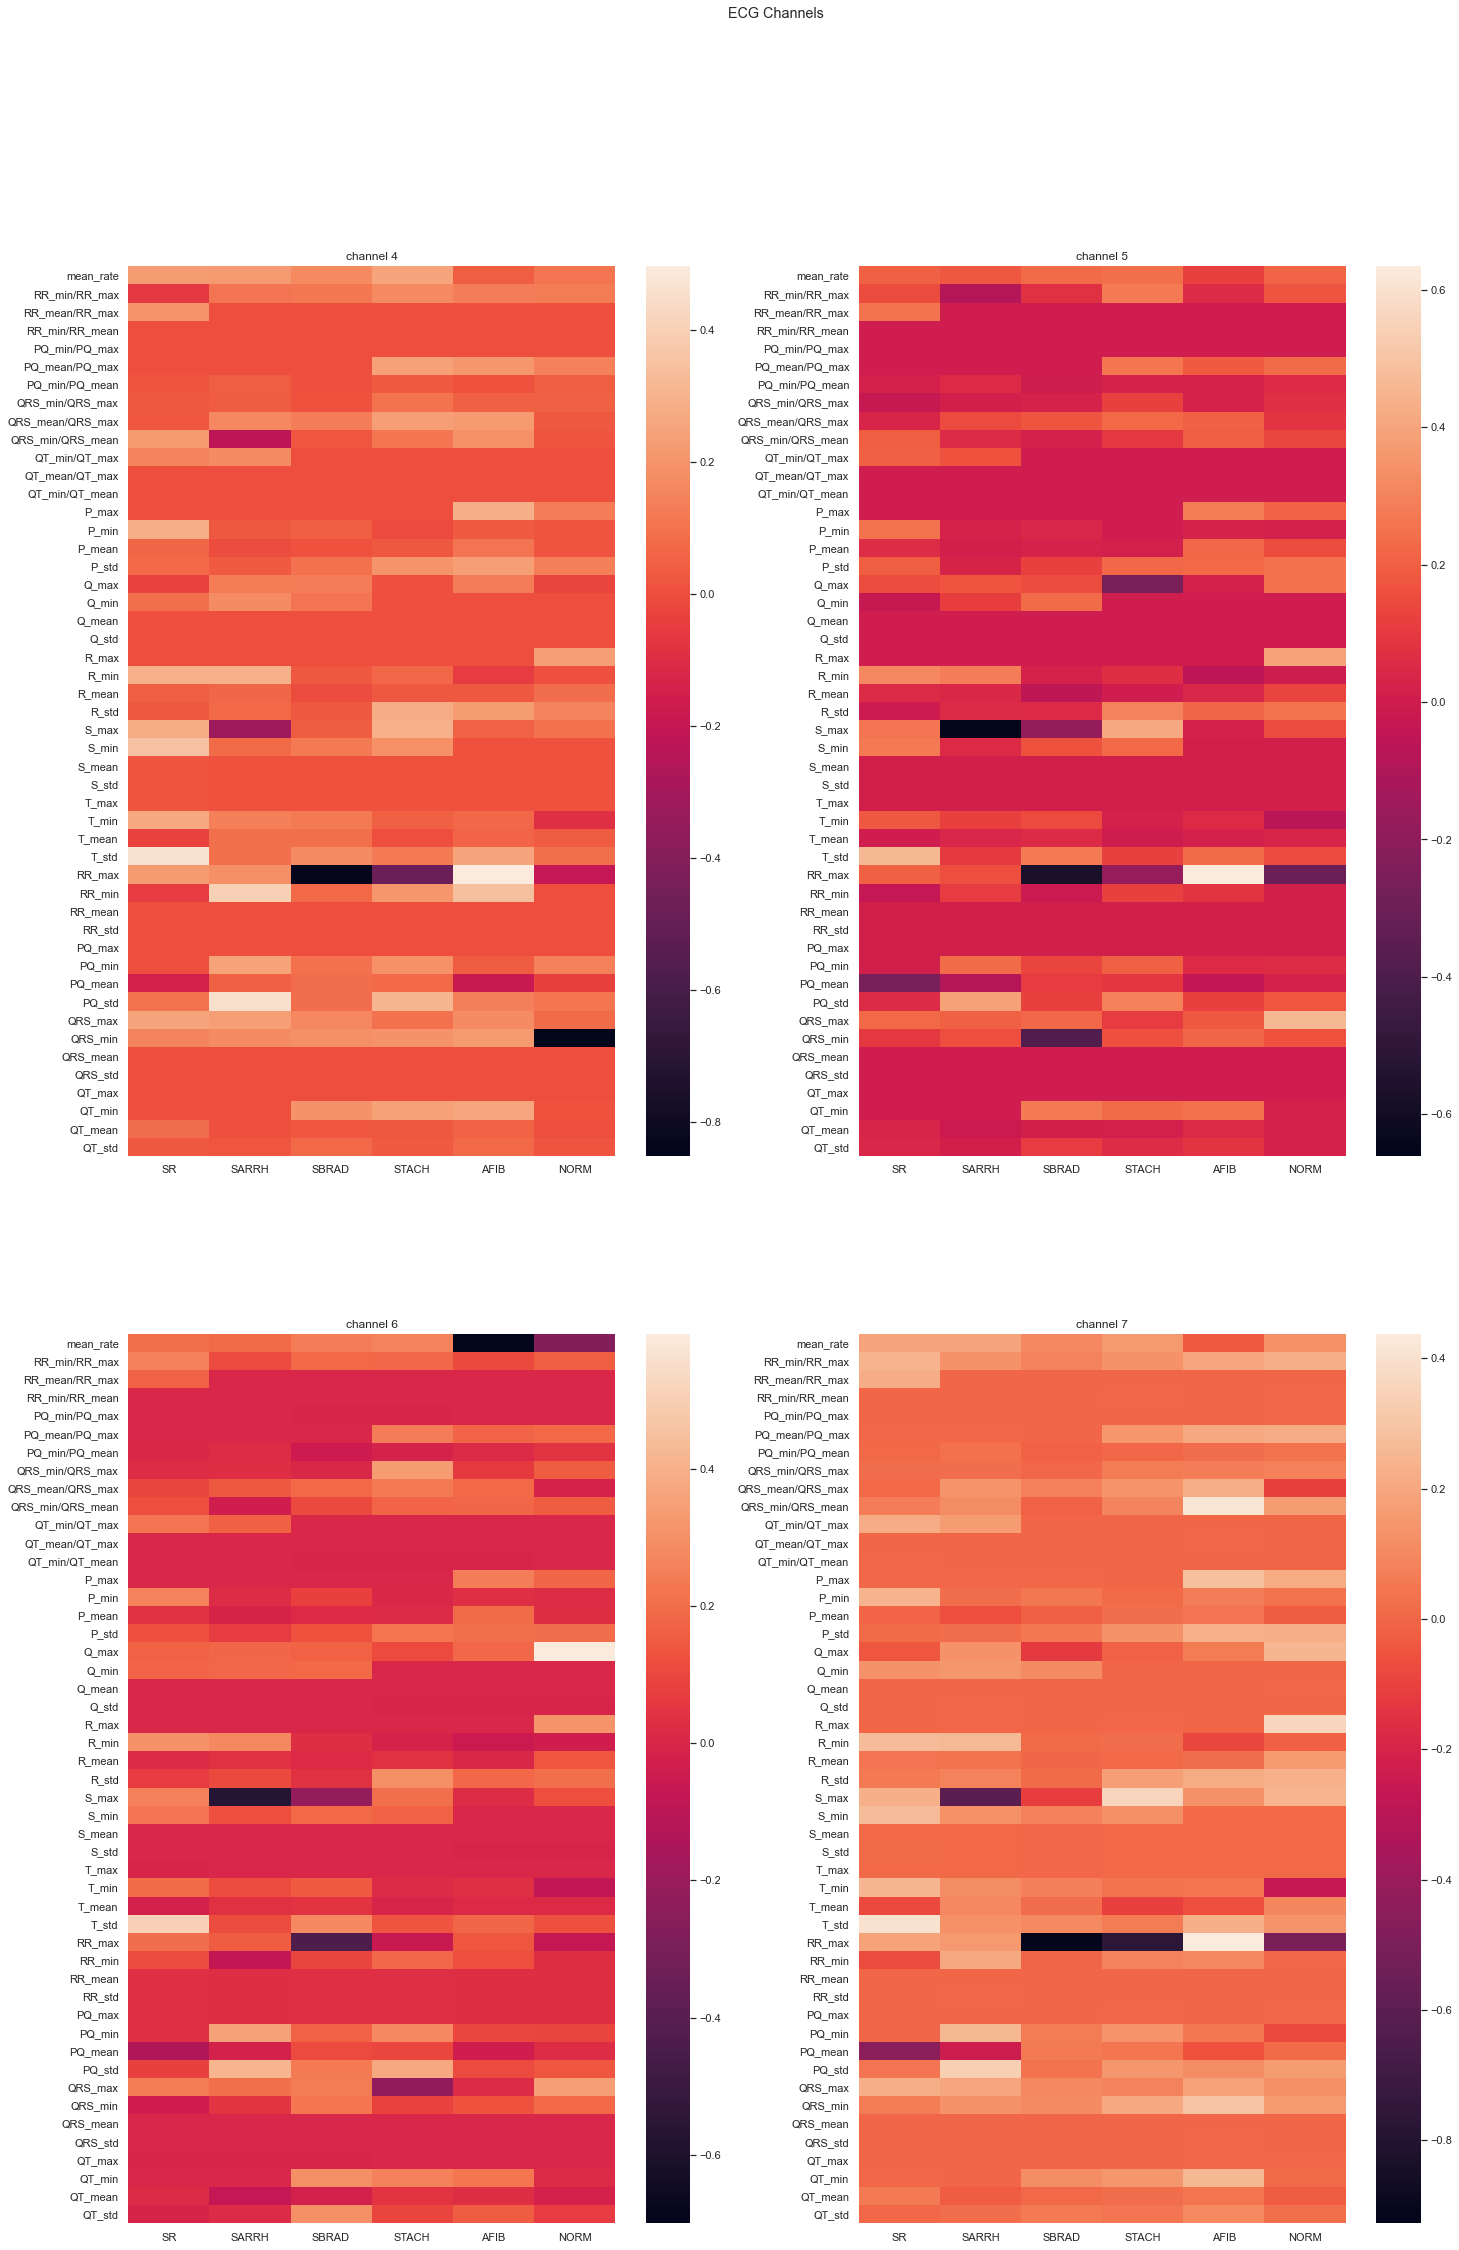

In [194]:
fig, axes = plt.subplots(2, 2, figsize=(24, 36))
fig.suptitle('ECG Channels')

for channel_i in range(4, 8):
    features_v = channel2features[channel_i]
    features_reshaped = np.concatenate(features_v).reshape(n, -1)
    i = int(channel_i/2) - 2
    j = (channel_i % 2)
    sns.heatmap(normalize(features_reshaped, axis=0), ax=axes[i, j],
                xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    axes[i, j].set_title(f'channel {channel_i}')

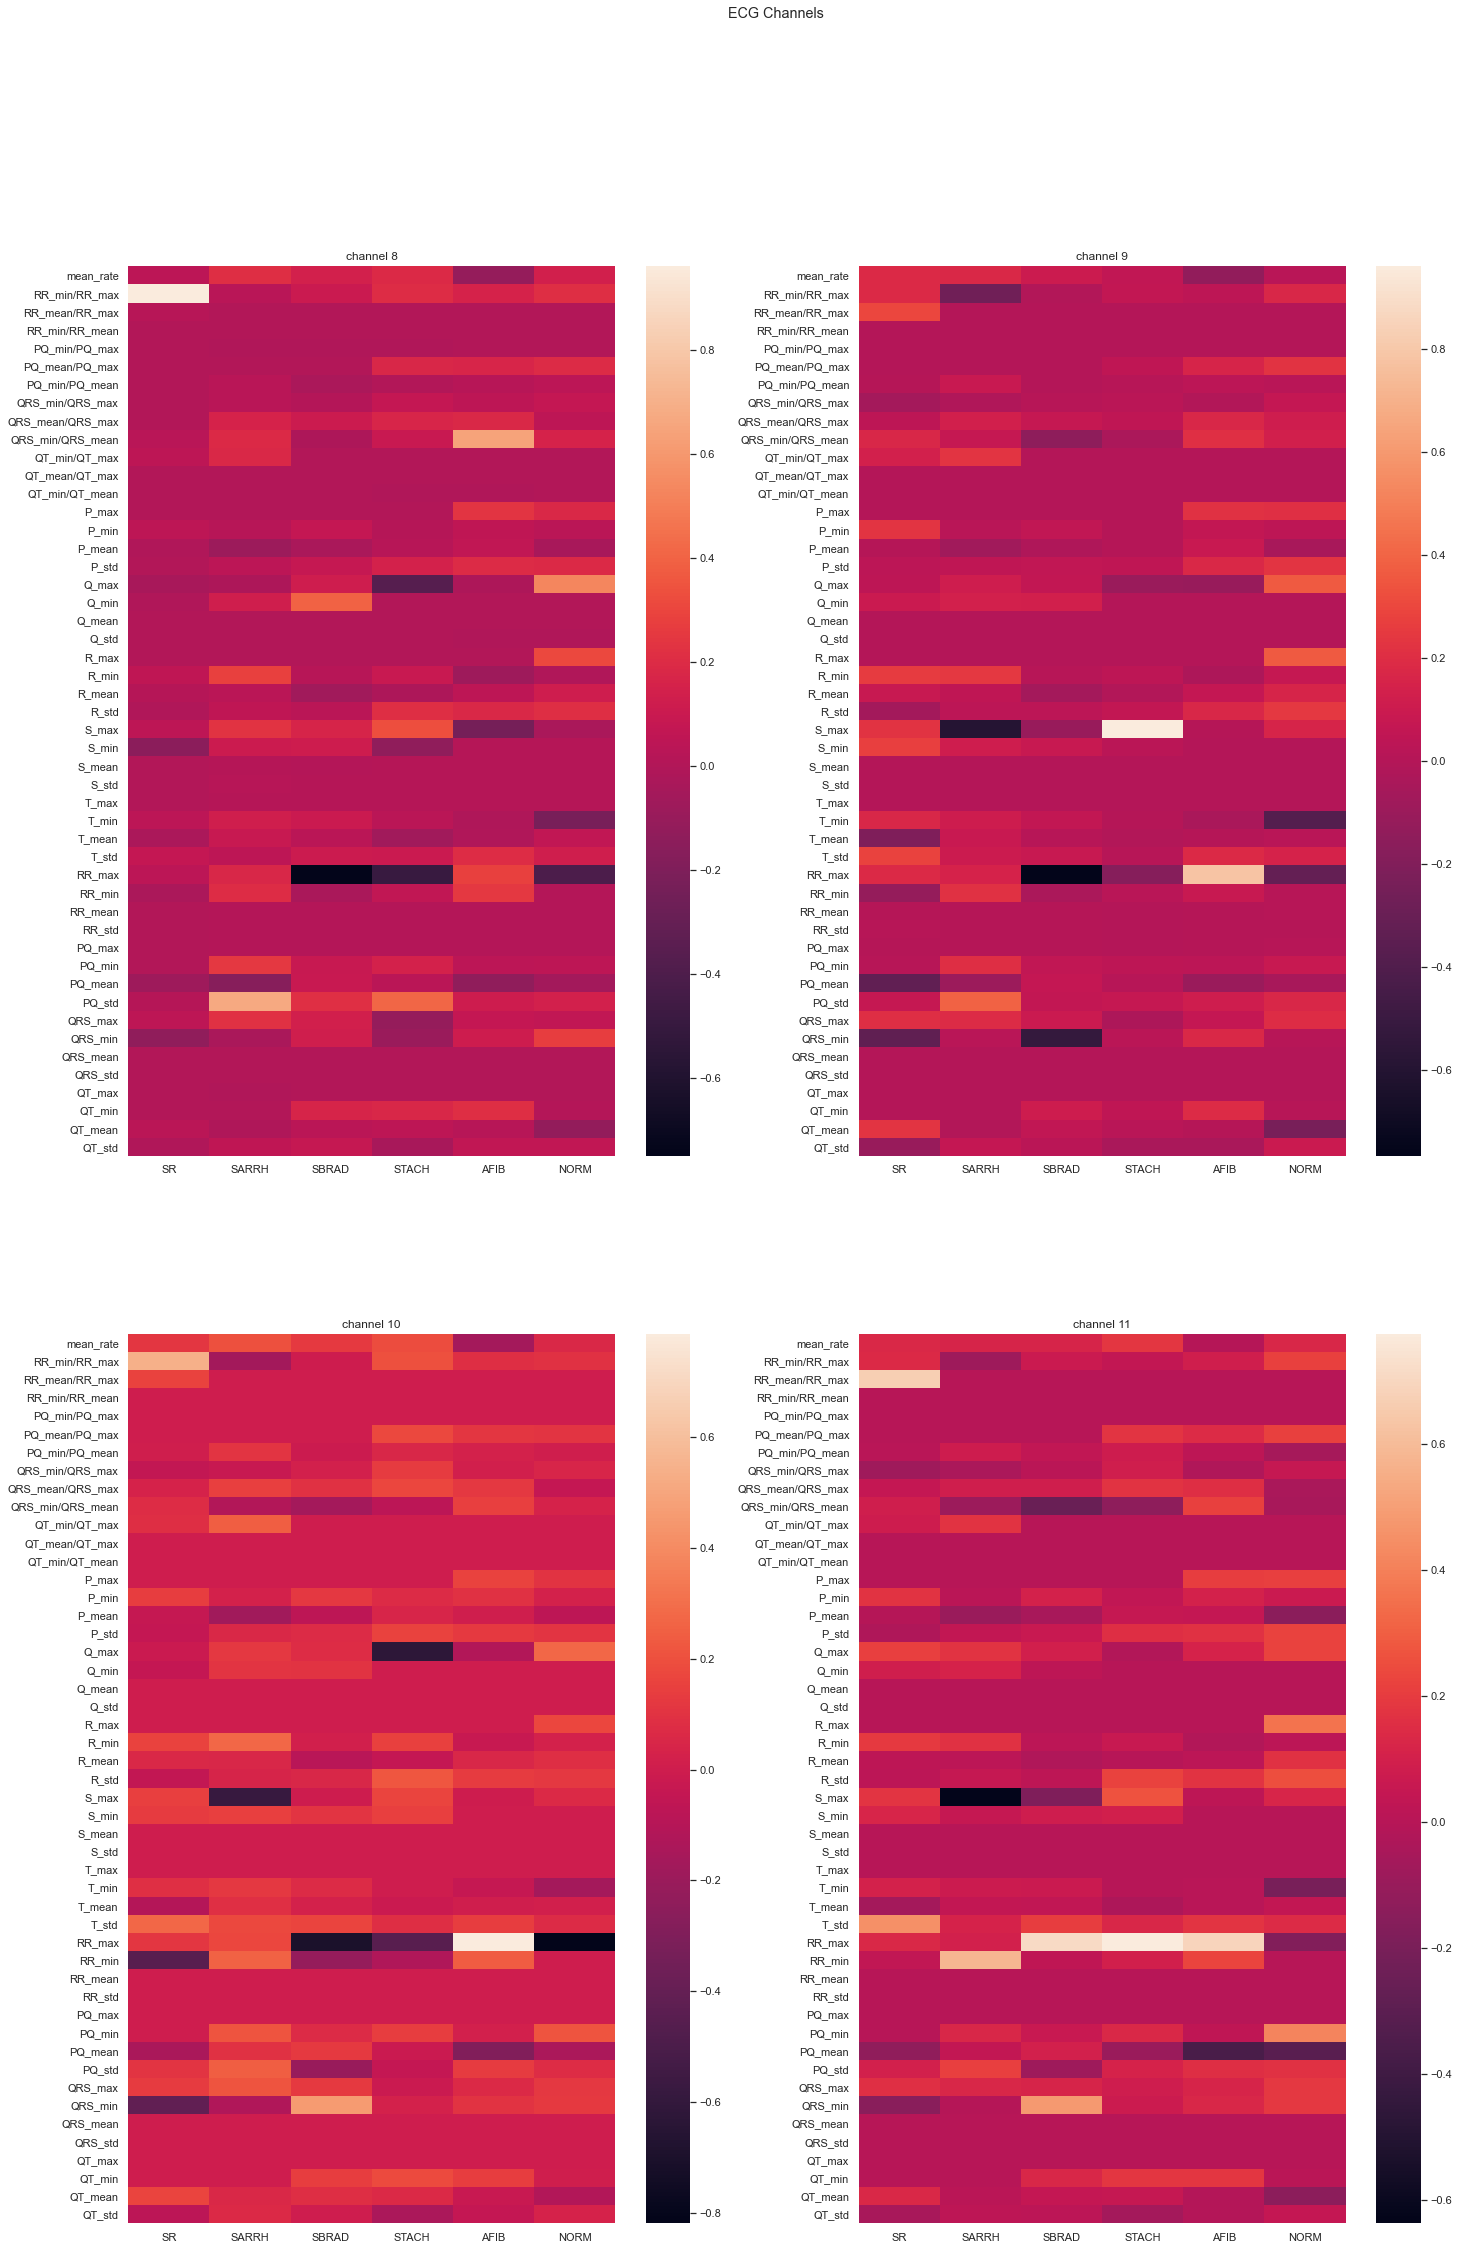

In [195]:
fig, axes = plt.subplots(2, 2, figsize=(24, 36))
fig.suptitle('ECG Channels')

for channel_i in range(8, 12):
    features_v = channel2features[channel_i]
    features_reshaped = np.concatenate(features_v).reshape(n, -1)
    i = int(channel_i/2) - 4
    j = (channel_i % 2)
    sns.heatmap(normalize(features_reshaped, axis=0), ax=axes[i, j],
                xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    axes[i, j].set_title(f'channel {channel_i}')

Самые контрастные фичи:

mean_rate,
RR_min, RR_max, RR_mean/max, RR_min/RR_max,
QRS_min, QRS_max,
PQ_mean,
S_max, Q_max

In [144]:
for i, label in enumerate(y_axis_labels):
    print(f'{i}: {label}')

0: mean_rate
1: RR_min/RR_max
2: RR_mean/RR_max
3: RR_min/RR_mean
4: PQ_min/PQ_max
5: PQ_mean/PQ_max
6: PQ_min/PQ_mean
7: QRS_min/QRS_max
8: QRS_mean/QRS_max
9: QRS_min/QRS_mean
10: QT_min/QT_max
11: QT_mean/QT_max
12: QT_min/QT_mean
13: P_max
14: P_min
15: P_mean
16: P_std
17: Q_max
18: Q_min
19: Q_mean
20: Q_std
21: R_max
22: R_min
23: R_mean
24: R_std
25: S_max
26: S_min
27: S_mean
28: S_std
29: T_max
30: T_min
31: T_mean
32: T_std
33: RR_max
34: RR_min
35: RR_mean
36: RR_std
37: PQ_max
38: PQ_min
39: PQ_mean
40: PQ_std
41: QRS_max
42: QRS_min
43: QRS_mean
44: QRS_std
45: QT_max
46: QT_min
47: QT_mean
48: QT_std
